## Team Members:

## 1- Asmaa Khaled Khorkhash

## 2- Reaal Salah Mohamed

## 3- Yasmeen Elsayed Mohamed

## 4- Somia Mosilhy Mohamed

## 5- Orkeed Waleed Mandour

## 6- Hams Ashraf Ahmed


## Introduction
Before diving into our analysis, we first needed to collect reliable data on SpaceY’s past launches. To do this, we accessed the SpaceX API, which provided detailed records of previous missions. By gathering information like rocket types, payloads, launch sites, and flight outcomes, we created a comprehensive dataset that serves as the foundation for our analysis. This data allows us to explore key factors that influence the success and efficiency of SpaceY’s launches.



We will:
1. Get data from APIs.
2. Collect Final Data
3. Perform data wrangling and cleaning.
4. Build a predictive model to forecast first-stage landing success.
5. Power BI


# 1. Get data from APIs

**Objectives**

In this lab, you will make a get request to the SpaceX API. You will also do some basic data wrangling and formating.

Request to the SpaceX API
Clean the requested data

In [1]:
import requests
import pandas as pd
import numpy as np  # For numerical calculations and data manipulation
import datetime  # To handle date and time formats

# Setting this option will print all collumns of a dataframe
pd.set_option('display.max_columns', None)
# Setting this option will print all of the data in a feature
pd.set_option('display.max_colwidth', None)

request data from the API using a specific URL that points to past SpaceX launches. We needed to ensure that our request was successful, so we checked the status code to make sure the data was retrieved without any issues. If something went wrong, an error message would alert us to the problem.

Once the data was successfully collected, we transformed it from its raw JSON format into a more organized and structured DataFrame. This gave us a clear and manageable view of the SpaceX launches, setting the stage for deeper analysis.

In [2]:
# URL for SpaceX launches data
spacex_url = "https://api.spacexdata.com/v4/launches/past"

# Request data from the API
response = requests.get(spacex_url)

# Check the status code to ensure the request was successful
if response.status_code != 200:
    raise Exception(f"API request failed with status code: {response.status_code}")

# Use json_normalize to convert the response JSON into a DataFrame
data = pd.json_normalize(response.json())


To better understand SpaceX launches, we gathered more details about the rockets, launch sites, payloads, and core performance.

We used rocket IDs to find booster versions, fetched launch site locations and names, and got payload information like mass and orbit. For the rocket cores, we collected data on block versions, reuse counts, and landing success.

By combining all this information, we created a richer dataset to analyze SpaceX missions more deeply.

In [3]:
def get_booster_versions(rocket_ids):
    versions = []
    for rocket_id in rocket_ids:
        try:
            response = requests.get(f"https://api.spacexdata.com/v4/rockets/{rocket_id}")
            versions.append(response.json().get('name', None))
        except Exception as e:
            print(f"Error fetching booster version for {rocket_id}: {e}")
            versions.append(None)
    return versions

def get_launch_sites(launchpad_ids):
    sites = []
    for launchpad_id in launchpad_ids:
        try:
            response = requests.get(f"https://api.spacexdata.com/v4/launchpads/{launchpad_id}")
            site = response.json()
            sites.append((site.get('longitude', None), site.get('latitude', None), site.get('name', None)))
        except Exception as e:
            print(f"Error fetching launch site for {launchpad_id}: {e}")
            sites.append((None, None, None))
    return sites

def get_payload_data(payload_ids):
    payloads = []
    for payload_id in payload_ids:
        try:
            response = requests.get(f"https://api.spacexdata.com/v4/payloads/{payload_id}")
            payload = response.json()
            payloads.append((payload.get('mass_kg', None), payload.get('orbit', None)))
        except Exception as e:
            print(f"Error fetching payload data for {payload_id}: {e}")
            payloads.append((None, None))
    return payloads

def get_core_data(cores):
    outcomes = []
    flights = []
    gridfins = []
    reused = []
    legs = []
    landing_pads = []
    blocks = []
    reused_counts = []
    serials = []

    for core in cores:
        if core['core'] is not None:
            try:
                response = requests.get(f"https://api.spacexdata.com/v4/cores/{core['core']}")
                response_data = response.json()
                blocks.append(response_data.get('block', None))
                reused_counts.append(response_data.get('reuse_count', None))
                serials.append(response_data.get('serial', None))
            except Exception as e:
                print(f"Error fetching core data for core ID {core['core']}: {e}")
                blocks.append(None)
                reused_counts.append(None)
                serials.append(None)
        else:
            blocks.append(None)
            reused_counts.append(None)
            serials.append(None)

        # Collect outcome and flight details
        outcomes.append(f"{core['landing_success']} {core['landing_type']}")
        flights.append(core['flight'])
        gridfins.append(core['gridfins'])
        reused.append(core['reused'])
        legs.append(core['legs'])
        landing_pads.append(core['landpad'])

    return (outcomes, flights, gridfins, reused, legs, landing_pads, blocks, reused_counts, serials)



In [4]:
# Lets take a subset of our dataframe keeping only the features we want and the flight number, and date_utc.
data = data[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

# We will remove rows with multiple cores because those are falcon rockets with 2 extra rocket boosters and rows that have multiple payloads in a single rocket.
data = data[data['cores'].map(len)==1]
data = data[data['payloads'].map(len)==1]

# Since payloads and cores are lists of size 1 we will also extract the single value in the list and replace the feature.
data['cores'] = data['cores'].map(lambda x : x[0])
data['payloads'] = data['payloads'].map(lambda x : x[0])

# We also want to convert the date_utc to a datetime datatype and then extracting the date leaving the time
data['date'] = pd.to_datetime(data['date_utc']).dt.date

# Using the date we will restrict the dates of the launches
data = data[data['date'] <= datetime.date(2020, 11, 13)]

# 2. Collect Final Data

In [5]:

# Collect all data
booster_versions = get_booster_versions(data['rocket'])
launch_sites_data = get_launch_sites(data['launchpad'])
payload_data = get_payload_data(data['payloads'])
core_data = get_core_data(data['cores'])

# Unpack launch sites data
longitudes, latitudes, launch_sites = zip(*launch_sites_data)

# Create a new DataFrame to hold all the collected data
final_data = pd.DataFrame({
    'FlightNumber': data['flight_number'],
    'Date': data['date'],
    'BoosterVersion': booster_versions,
    'PayloadMass': [mass for mass, _ in payload_data],
    'Orbit': [orbit for _, orbit in payload_data],
    'LaunchSite': launch_sites,
    'Outcome': core_data[0],
    'Flights': core_data[1],
    'GridFins': core_data[2],
    'Reused': core_data[3],
    'Legs': core_data[4],
    'LandingPad': core_data[5],
    'Block': core_data[6],
    'ReusedCount': core_data[7],
    'Serial': core_data[8],
    'Longitude': longitudes,
    'Latitude': latitudes
})

# Display the final DataFrame
final_data.head(10)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2006-03-24,Falcon 1,20.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin1A,167.743129,9.047721
1,2,2007-03-21,Falcon 1,NaN,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2A,167.743129,9.047721
3,4,2008-09-28,Falcon 1,165.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2C,167.743129,9.047721
4,5,2009-07-13,Falcon 1,200.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin3C,167.743129,9.047721
5,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
7,8,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
9,10,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
10,11,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
11,12,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857
12,13,2014-01-06,Falcon 9,3325.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1005,-80.577366,28.561857


In [6]:
# Call getBoosterVersion
get_booster_versions(data['rocket'][:7])

['Falcon 1',
 'Falcon 1',
 'Falcon 1',
 'Falcon 1',
 'Falcon 9',
 'Falcon 9',
 'Falcon 9']

To focus our analysis, we filtered the dataset to exclude any entries where the booster version is "Falcon 1." This gives us a new dataset, data_falcon9, that contains only the launches involving other booster versions, such as Falcon

In [7]:
# Hint data['BoosterVersion']!='Falcon 1'
data_falcon9 = final_data[final_data['BoosterVersion'] == 'Falcon 9']

In [8]:
data_falcon9.loc[:,'FlightNumber'] = list(range(1, data_falcon9.shape[0]+1))
data_falcon9

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
5,1,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
7,2,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
9,3,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
10,4,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
11,5,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,86,2020-09-03,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,2,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1060,-80.603956,28.608058
102,87,2020-10-06,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,3,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,13,B1058,-80.603956,28.608058
103,88,2020-10-18,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,6,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1051,-80.603956,28.608058
104,89,2020-10-24,Falcon 9,15600.0,VLEO,CCSFS SLC 40,True ASDS,3,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,12,B1060,-80.577366,28.561857


In [9]:
data_falcon9.info()

<class 'pandas.core.frame.DataFrame'>
Index: 90 entries, 5 to 105
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   FlightNumber    90 non-null     int64  
 1   Date            90 non-null     object 
 2   BoosterVersion  90 non-null     object 
 3   PayloadMass     85 non-null     float64
 4   Orbit           90 non-null     object 
 5   LaunchSite      90 non-null     object 
 6   Outcome         90 non-null     object 
 7   Flights         90 non-null     int64  
 8   GridFins        90 non-null     bool   
 9   Reused          90 non-null     bool   
 10  Legs            90 non-null     bool   
 11  LandingPad      64 non-null     object 
 12  Block           90 non-null     float64
 13  ReusedCount     90 non-null     int64  
 14  Serial          90 non-null     object 
 15  Longitude       90 non-null     float64
 16  Latitude        90 non-null     float64
dtypes: bool(3), float64(4), int64(3), object(

In [10]:
data_falcon9.loc[:,'FlightNumber'] = list(range(1, data_falcon9.shape[0]+1))
data_falcon9

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
5,1,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
7,2,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
9,3,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
10,4,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
11,5,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,86,2020-09-03,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,2,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1060,-80.603956,28.608058
102,87,2020-10-06,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,3,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,13,B1058,-80.603956,28.608058
103,88,2020-10-18,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,6,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1051,-80.603956,28.608058
104,89,2020-10-24,Falcon 9,15600.0,VLEO,CCSFS SLC 40,True ASDS,3,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,12,B1060,-80.577366,28.561857


In [11]:
data_falcon9.info()

<class 'pandas.core.frame.DataFrame'>
Index: 90 entries, 5 to 105
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   FlightNumber    90 non-null     int64  
 1   Date            90 non-null     object 
 2   BoosterVersion  90 non-null     object 
 3   PayloadMass     85 non-null     float64
 4   Orbit           90 non-null     object 
 5   LaunchSite      90 non-null     object 
 6   Outcome         90 non-null     object 
 7   Flights         90 non-null     int64  
 8   GridFins        90 non-null     bool   
 9   Reused          90 non-null     bool   
 10  Legs            90 non-null     bool   
 11  LandingPad      64 non-null     object 
 12  Block           90 non-null     float64
 13  ReusedCount     90 non-null     int64  
 14  Serial          90 non-null     object 
 15  Longitude       90 non-null     float64
 16  Latitude        90 non-null     float64
dtypes: bool(3), float64(4), int64(3), object(

In [12]:
data_falcon9=data_falcon9.set_index('Date')

In [13]:
data_falcon9=data_falcon9.drop('BoosterVersion',axis=1)

# 3. Perform data wrangling and cleaning.

### 3.1 Check for Nulls

In [14]:
data_falcon9.isnull().sum()

,0
FlightNumber,0
PayloadMass,5
Orbit,0
LaunchSite,0
Outcome,0
Flights,0
GridFins,0
Reused,0
Legs,0
LandingPad,26


In [15]:
# Calculate the percentage of missing values for each column in the DataFrame 'data_falcon9'
percent_missing = data_falcon9.isnull().sum() * 100 / len(data_falcon9)
percent_missing = percent_missing.apply(lambda x: f'{x:.0f}%')
percent_missing_df = pd.DataFrame({ 'percent_missing': percent_missing})
print(percent_missing_df)

             percent_missing
FlightNumber              0%
PayloadMass               6%
Orbit                     0%
LaunchSite                0%
Outcome                   0%
Flights                   0%
GridFins                  0%
Reused                    0%
Legs                      0%
LandingPad               29%
Block                     0%
ReusedCount               0%
Serial                    0%
Longitude                 0%
Latitude                  0%


## Handel missing values

In [16]:
# Fill with mean
data_falcon9['PayloadMass'].fillna(data_falcon9['PayloadMass'].mean(), inplace=True)
data_falcon9['LandingPad'].fillna(data_falcon9['LandingPad'].mode()[0], inplace=True)
data_falcon9.isnull().sum()

<ipython-input-16-1f6c57f456a8>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_falcon9['PayloadMass'].fillna(data_falcon9['PayloadMass'].mean(), inplace=True)
<ipython-input-16-1f6c57f456a8>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].me

,0
FlightNumber,0
PayloadMass,0
Orbit,0
LaunchSite,0
Outcome,0
Flights,0
GridFins,0
Reused,0
Legs,0
LandingPad,0


# 3.2 Handling Categorical Columns

In [17]:
# one hot encoding
data_falcon9 = pd.get_dummies(data_falcon9, columns=['LandingPad'], drop_first=True,dtype='int')

In [18]:
#label encoder
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
binary_cols = ['GridFins','Reused','Legs','Serial' ,'LaunchSite','Orbit']
for col in binary_cols:
    data_falcon9[col] = label_encoder.fit_transform(data_falcon9[col])

In [19]:
data_falcon9.head()

,FlightNumber,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,Block,ReusedCount,Serial,Longitude,Latitude,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc
Date,,,,,,,,,,,,,,,,,,
2010-06-04,1,6123.547647,5,0,None None,1,0,0,0,1.0,0,0,-80.577366,28.561857,0,1,0,0
2012-05-22,2,525.000000,5,0,None None,1,0,0,0,1.0,0,1,-80.577366,28.561857,0,1,0,0
2013-03-01,3,677.000000,4,0,None None,1,0,0,0,1.0,0,2,-80.577366,28.561857,0,1,0,0
2013-09-29,4,500.000000,7,2,False Ocean,1,0,0,0,1.0,0,3,-120.610829,34.632093,0,1,0,0
2013-12-03,5,3170.000000,2,0,None None,1,0,0,0,1.0,0,4,-80.577366,28.561857,0,1,0,0


In [20]:
# 2: Calculate the number and occurrence of each orbit
data_falcon9['Orbit'].value_counts()

,count
Orbit,
2,27
4,21
10,14
7,9
5,7
9,5
6,3
0,1
3,1


# 3.3 Classifying Landing Outcomes: Good (1) vs. Bad (0)


In [21]:
 #3: Calculate the number and occurence of mission outcome per orbit type
landing_outcomes = data_falcon9['Outcome'].value_counts()
landing_outcomes

,count
Outcome,
True ASDS,41
None None,19
True RTLS,14
False ASDS,6
True Ocean,5
False Ocean,2
None ASDS,2
False RTLS,1


In [22]:
for i,outcome in enumerate(landing_outcomes.keys()):
    print(i,outcome)

0 True ASDS
1 None None
2 True RTLS
3 False ASDS
4 True Ocean
5 False Ocean
6 None ASDS
7 False RTLS


In [23]:
bad_outcomes=set(landing_outcomes.keys()[[1,3,5,6,7]])
bad_outcomes

{'False ASDS', 'False Ocean', 'False RTLS', 'None ASDS', 'None None'}

In [24]:
# landing_class = 0 if bad_outcome
# landing_class = 1 otherwise
landing_class = []
for key, value in data_falcon9['Outcome'].items():
     if value in bad_outcomes:
        landing_class.append(0)
     else:
        landing_class.append(1)

In [25]:
data_falcon9=data_falcon9.drop('Outcome',axis=1)
data_falcon9['new_Outcome']=landing_class
data_falcon9[['new_Outcome']].head(10)

,new_Outcome
Date,
2010-06-04,0
2012-05-22,0
2013-03-01,0
2013-09-29,0
2013-12-03,0
2014-01-06,0
2014-04-18,1
2014-07-14,1
2014-08-05,0


In [26]:

data_falcon9.info()

<class 'pandas.core.frame.DataFrame'>
Index: 90 entries, 2010-06-04 to 2020-11-05
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   FlightNumber                         90 non-null     int64  
 1   PayloadMass                          90 non-null     float64
 2   Orbit                                90 non-null     int64  
 3   LaunchSite                           90 non-null     int64  
 4   Flights                              90 non-null     int64  
 5   GridFins                             90 non-null     int64  
 6   Reused                               90 non-null     int64  
 7   Legs                                 90 non-null     int64  
 8   Block                                90 non-null     float64
 9   ReusedCount                          90 non-null     int64  
 10  Serial                               90 non-null     int64  
 11  Longitude             


- **True Ocean**: Successful landing in a specific ocean region.
- **False Ocean**: Unsuccessful landing in a specific ocean region.
- **True RTLS (Return to Launch Site)**: Successful landing on a ground pad.
- **False RTLS**: Unsuccessful landing on a ground pad.
- **True ASDS (Autonomous Spaceport Drone Ship)**: Successful landing on a drone ship.
- **False ASDS**: Unsuccessful landing on a drone ship.
- **None ASDS / None None**: Failure to land.

# 3.4 Check Duplicates

In [27]:
data_falcon9.duplicated().sum()

0

# 3.5 Check for Outlayers

In [28]:
import pandas as pd

# Assuming 'data' is your dataset

# Function to identify outliers using IQR
def find_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Return a boolean series indicating outliers
    return (data[column] < lower_bound) | (data[column] > upper_bound)

# Dictionary to hold outlier information for each column
outlier_info = {}

# Iterate through the numerical columns and find outliers
for col in data.select_dtypes(include=['float64', 'int64']).columns:
    outlier_mask = find_outliers_iqr(data, col)
    outlier_indices = data[outlier_mask].index.tolist()

    if outlier_indices:
        outlier_info[col] = outlier_indices

# Display the outlier information
for column, indices in outlier_info.items():
    print(f"Outliers in '{column}': {indices}")




### Handling outlayers

In [29]:
import pandas as pd

# Assuming 'data' is your dataset

# Function to identify outliers using IQR
def find_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Return a boolean series indicating outliers
    return (data[column] < lower_bound) | (data[column] > upper_bound)

# Create a mask for all outliers across numerical columns
# Use data.index to ensure the index matches
outlier_mask = pd.Series([False] * len(data), index=data.index)

# Iterate through the numerical columns and update the outlier mask
for col in data.select_dtypes(include=['float64', 'int64']).columns:
    outlier_mask |= find_outliers_iqr(data, col)  # Use |= to accumulate the mask

# Remove outliers from the dataset
data_cleaned = data[~outlier_mask]  # Keep only non-outlier rows

# Display the cleaned dataset
print("Cleaned dataset shape:", data_cleaned.shape)

Cleaned dataset shape: (94, 7)


In [30]:
data_cleaned.to_csv('Falcon_data_cleaned.csv', index=False)

**attributes:**

1. **FlightNumber**: This likely represents the unique identifier for each flight.
2. **Date**: The date when the flight took place.
3. **BoosterVersion**: The version of the booster used in the flight.
4. **PayloadMass**: The mass of the payload being carried by the flight (in kilograms).
5. **Orbit**: The orbit in which the payload is intended to be placed.
6. **LaunchSite**: The location from which the flight was launched.
7. **Outcome**: The result of the flight (e.g., success, failure).
8. **Flights**: The number of flights the booster has completed.
9. **GridFins**: Indicates whether the flight used grid fins (a type of control surface).
10. **Reused**: Indicates whether the booster was reused from a previous flight.
11. **Legs**: Indicates whether the booster had landing legs.
12. **LandingPad**: The specific landing pad used for the booster (if applicable).
13. **Block**: The block number of the booster, indicating its version or generation.
14. **ReusedCount**: The number of times the booster has been reused.
15. **Serial**: The serial number of the booster.
16. **Longitude**: The longitude coordinate of the launch or landing site.
17. **Latitude**: The latitude coordinate of the launch or landing site.

These columns provide a comprehensive overview of each flight, including details about the booster, payload, launch, and landing. This information can be crucial for analyzing flight performance, booster reuse, and overall mission success.


# 4. Modeling

In [31]:
# Importing necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt


In [32]:
X=data_falcon9.drop('new_Outcome',axis=1)
y=data_falcon9['new_Outcome']
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 4.1 Handling Class Imbalance

In [33]:
# Assuming X, y are already defined in the environment.
# Handle Imbalanced Data
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)



# 4.2 Spliting Data

In [34]:
# Split the Data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


# 4.3 Feature Scaling

In [35]:
# Scale the Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [57]:
# Initialize Results List
results = []
# Function to Evaluate Models
def evaluate_model(model, model_name):
    model.fit(X_train_scaled, y_train)

    # Predictions on training data
    y_train_pred = model.predict(X_train_scaled)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_report = classification_report(y_train, y_train_pred, output_dict=True)

    # Predictions on test data
    y_test_pred = model.predict(X_test_scaled)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_report = classification_report(y_test, y_test_pred, output_dict=True)

    # Append results for both train and test
    results.append({
        'Model': model_name,
        'Train Accuracy': train_accuracy,
        'Train Precision': train_report['weighted avg']['precision'],
        'Train Recall': train_report['weighted avg']['recall'],
        'Train F1-Score': train_report['weighted avg']['f1-score'],
        'Test Accuracy': test_accuracy,
        'Test Precision': test_report['weighted avg']['precision'],
        'Test Recall': test_report['weighted avg']['recall'],
        'Test F1-Score': test_report['weighted avg']['f1-score']
    })
    return y_test_pred

In [37]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt
# Function to plot learning curves
def plot_learning_curve(model, model_name):
    train_sizes, train_scores, test_scores = learning_curve(model, X_resampled, y_resampled, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    # Plot the learning curve
    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_scores_mean, label="Training Score", marker='o')
    plt.plot(train_sizes, test_scores_mean, label="Validation Score", marker='o')
    plt.xlabel("Training Size")
    plt.ylabel("Accuracy")
    plt.title(f"Learning Curve for {model_name}")
    plt.legend()
    plt.grid()
    plt.show()


# 4.4 Models

# *4.4.1 Logistic Regression*

In [38]:
# Train Different Models
# Logistic Regression
log_reg = LogisticRegression(random_state=42, max_iter=500, penalty='l2', C=0.1, solver='liblinear')
evaluate_model(log_reg, "Logistic Regression")


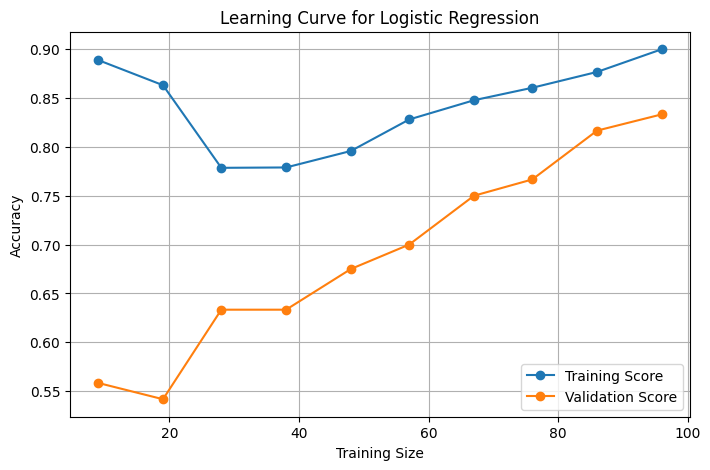

In [39]:
# Plot Learning Curve for Logistic Regression
plot_learning_curve(log_reg, "Logistic Regression")


In [40]:
# Decision Tree
dt = DecisionTreeClassifier(max_depth=4, min_samples_split=30, min_samples_leaf=10, random_state=42)
evaluate_model(dt, "Decision Tree")

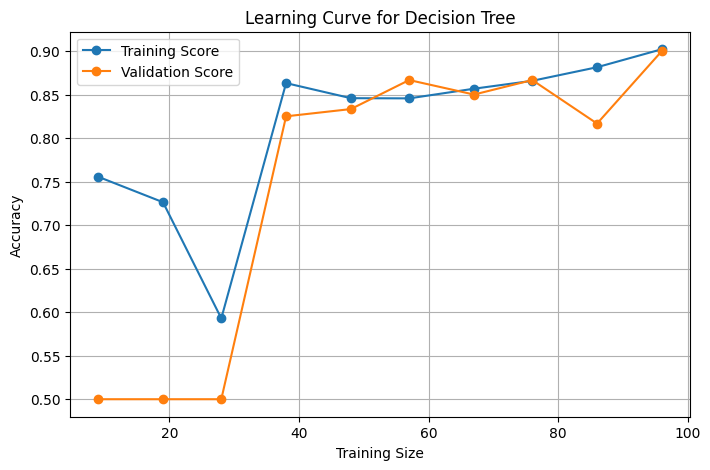

In [41]:
# Plot Learning Curve for Decision Tree
plot_learning_curve(dt, "Decision Tree")


# **4.4.2Random Forest Classifier**

In [42]:
# Random Forest
rf = RandomForestClassifier(max_depth=7, n_estimators=100, min_samples_split=10, random_state=42)
evaluate_model(rf, "Random Forest")


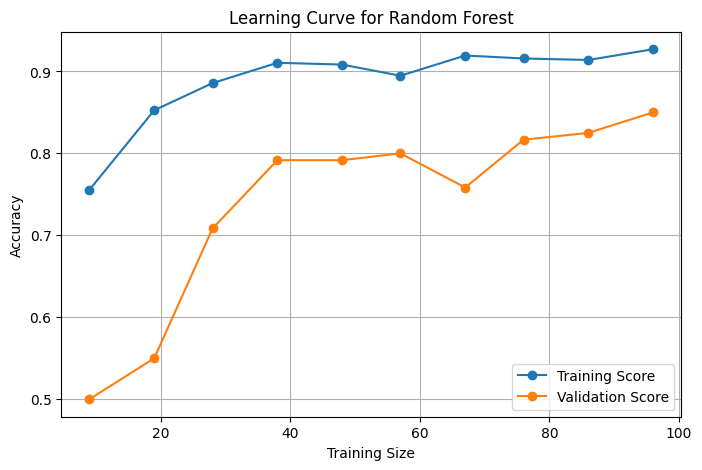

In [43]:
# Plot Learning Curve for Random Forest
plot_learning_curve(rf, "Random Forest")



# **4.4.3K-Nearest Neighbors**

In [44]:
# K-Nearest Neighbors
knn_params = {'n_neighbors': [3, 5, 7]}
knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, knn_params, cv=5)
knn_grid.fit(X_train_scaled, y_train)
evaluate_model(knn_grid.best_estimator_, "K-Nearest Neighbors")


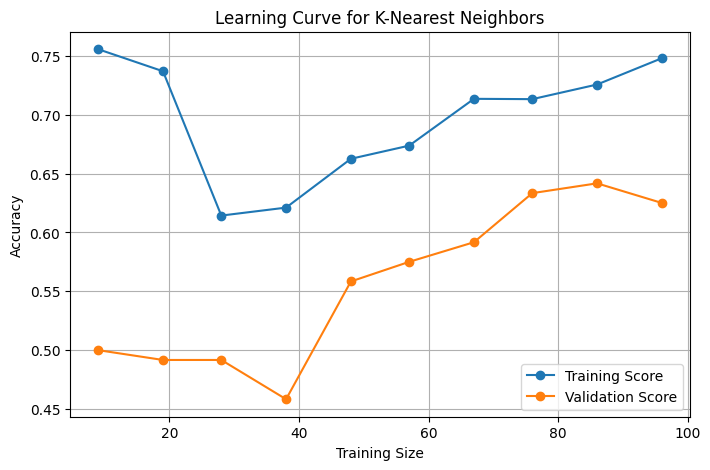

In [45]:
# Plot Learning Curve for K-Nearest Neighbors
plot_learning_curve(knn_grid.best_estimator_, "K-Nearest Neighbors")


# **4.4.4 SVC**

In [46]:
# Support Vector Machine
from sklearn.svm import SVC # Import the SVC class from scikit-learn

#svc_params = {'C': [0.1, 1, 10], 'kernel': ['linear']}
svc_params = {'C': [0.01, 0.1, 1], 'kernel': ['linear']}
svc = SVC() # Instantiate the SVC class before passing it to GridSearchCV
svc_grid = GridSearchCV(svc, svc_params, cv=5, n_jobs=-1)
svc_grid.fit(X_train_scaled, y_train)
evaluate_model(svc_grid.best_estimator_, "Support Vector Machine")


## 4.5 Compare Results

In [47]:
# Compare Results
results_df = pd.DataFrame(results)
print(results_df)


                    Model  Train Accuracy  Train Precision  Train Recall  \
0     Logistic Regression        0.854167         0.864736      0.854167   
1           Decision Tree        0.895833         0.898430      0.895833   
2           Random Forest        0.937500         0.937500      0.937500   
3     K-Nearest Neighbors        0.864583         0.878311      0.864583   
4  Support Vector Machine        0.854167         0.864736      0.854167   

   Train F1-Score  Test Accuracy  Test Precision  Test Recall  Test F1-Score  
0        0.853404       0.875000        0.898438     0.875000       0.871597  
1        0.895561       0.916667        0.916667     0.916667       0.916667  
2        0.937500       0.958333        0.961310     0.958333       0.958113  
3        0.863653       0.875000        0.898438     0.875000       0.871597  
4        0.853404       0.875000        0.898438     0.875000       0.871597  


## 4.6 Plotting Accuracy Results

<Figure size 1400x700 with 0 Axes>

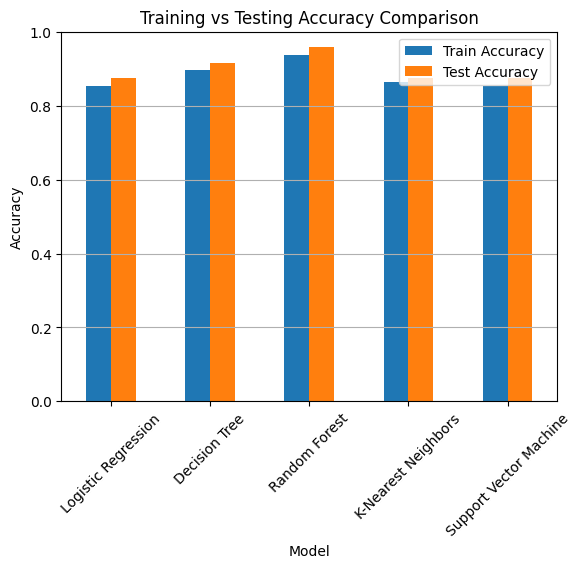

In [48]:
# Plotting Accuracy Results
plt.figure(figsize=(14, 7))
results_df.set_index('Model')[['Train Accuracy', 'Test Accuracy']].plot(kind='bar', color=['#1f77b4', '#ff7f0e'])
plt.title('Training vs Testing Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(axis='y')
plt.legend(loc='best')
plt.show()


# 4.7 Plotting F1-Score Results

<Figure size 1400x700 with 0 Axes>

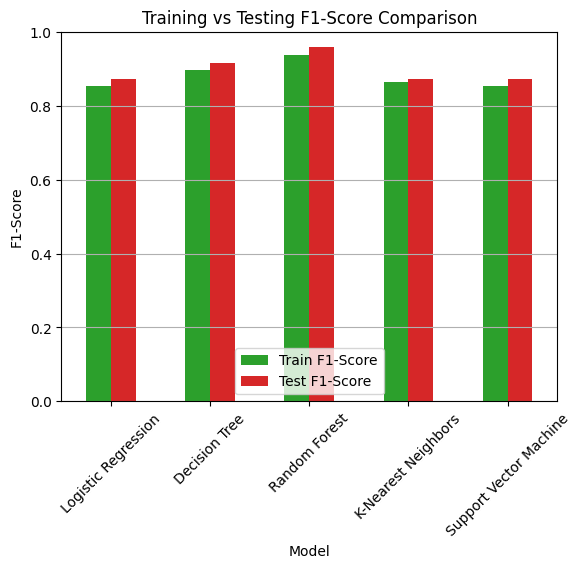

In [49]:
# Plotting F1-Score Results
plt.figure(figsize=(14, 7))
results_df.set_index('Model')[['Train F1-Score', 'Test F1-Score']].plot(kind='bar', color=['#2ca02c', '#d62728'])
plt.title('Training vs Testing F1-Score Comparison')
plt.ylabel('F1-Score')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(axis='y')
plt.legend(loc='best')
plt.show()


# 4.8 Best Model Evaluation

In [50]:
# Best Model Evaluation
best_model_index = results_df['Test F1-Score'].idxmax()
best_model = results_df.iloc[best_model_index]

print("\nBest Model:")
print(f"Model: {best_model['Model']}")
print(f"Test Accuracy: {best_model['Test Accuracy']:.4f}")
print(f"Test Precision: {best_model['Test Precision']:.4f}")
print(f"Test Recall: {best_model['Test Recall']:.4f}")
print(f"Test F1-Score: {best_model['Test F1-Score']:.4f}")



Best Model:
Model: Random Forest
Test Accuracy: 0.9583
Test Precision: 0.9613
Test Recall: 0.9583
Test F1-Score: 0.9581


In [51]:
# Importing additional library for ROC Curve
from sklearn.metrics import roc_curve, auc


In [52]:
# Function to Plot ROC Curve
def plot_roc_curve(model, model_name):
    y_score = model.predict_proba(X_test_scaled)[:, 1]  # Get the predicted probabilities for the positive class
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')



## 4.9 Plotting ROC Curves

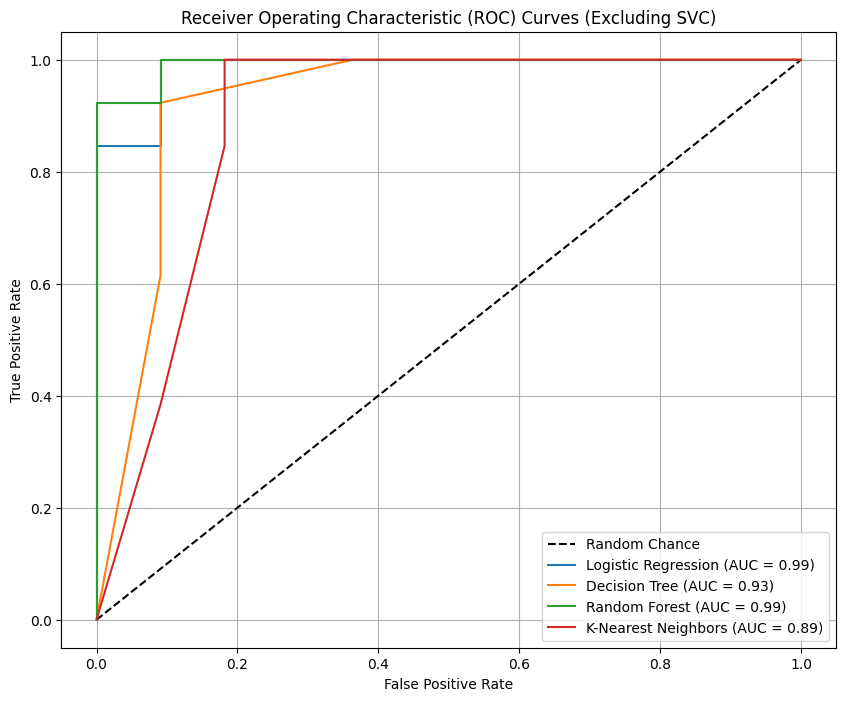

In [53]:
# Plotting ROC Curves
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')  # Diagonal line

# Evaluate each model's ROC curve
for result in results:
    model_name = result['Model']

    # Select the trained model based on its name, skipping SVC
    if model_name == "Logistic Regression":
        model = log_reg
    elif model_name == "Decision Tree":
        model = dt
    elif model_name == "Random Forest":
        model = rf
    elif model_name == "K-Nearest Neighbors":
        model = knn_grid.best_estimator_
    # Skip Support Vector Machine
    else:
        continue

    plot_roc_curve(model, model_name)

# Formatting the plot
plt.title('Receiver Operating Characteristic (ROC) Curves (Excluding SVC)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()


# 4.10 Predict on Test Data

In [54]:
# Function to Predict on Test Data
def predict_on_test(model, model_name, X_test):
    y_test_pred = model.predict(X_test)
    return pd.DataFrame({
        'Model': [model_name] * len(y_test_pred),
        'Predicted Values': y_test_pred
    })

# Example usage:
log_reg_predictions = predict_on_test(log_reg, "Logistic Regression", X_test_scaled)
print(log_reg_predictions[:9])


                 Model  Predicted Values
0  Logistic Regression                 1
1  Logistic Regression                 1
2  Logistic Regression                 0
3  Logistic Regression                 1
4  Logistic Regression                 1
5  Logistic Regression                 1
6  Logistic Regression                 1
7  Logistic Regression                 0
8  Logistic Regression                 1


In [59]:
rf_test_predictions = evaluate_model(rf, "Random Forest")
print(rf_test_predictions[:9])


[1 1 0 1 1 1 1 0 1]


# 5.Power Bi

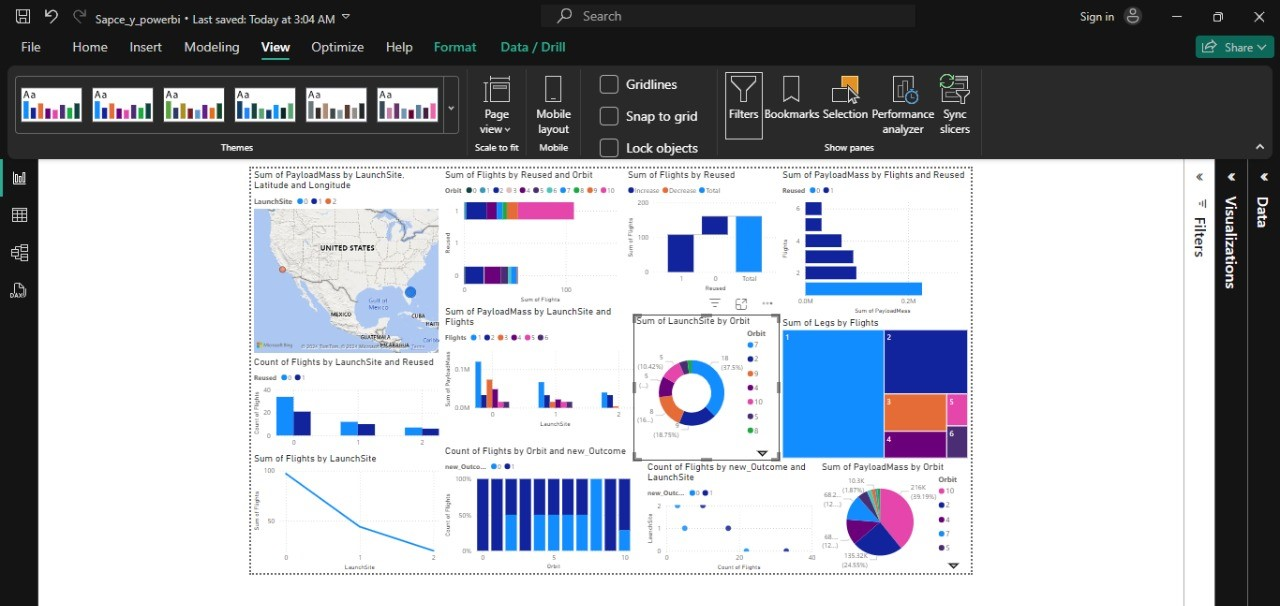